/tmp/ipykernel_232762/1227272170.py:17: DtypeWarning: Columns (2,3,4,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/01_raw/weather_data.csv")


Test MSE: 1.518


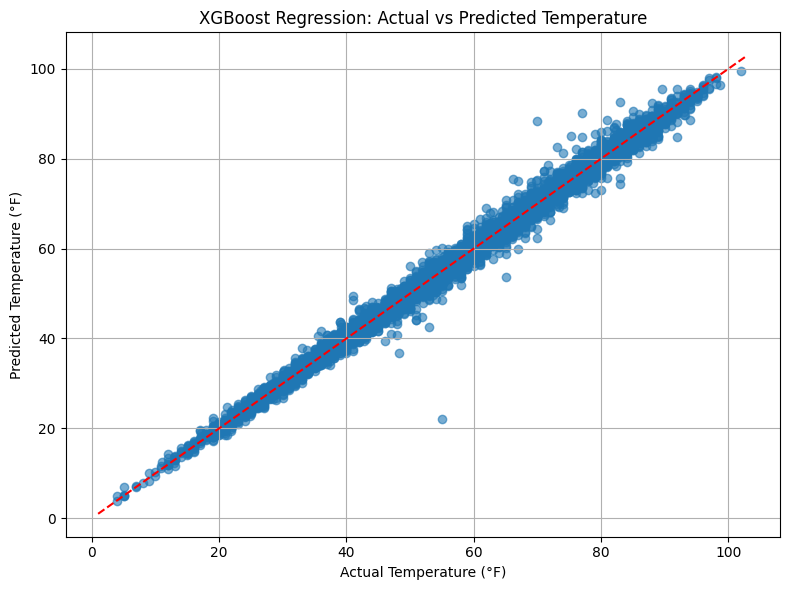

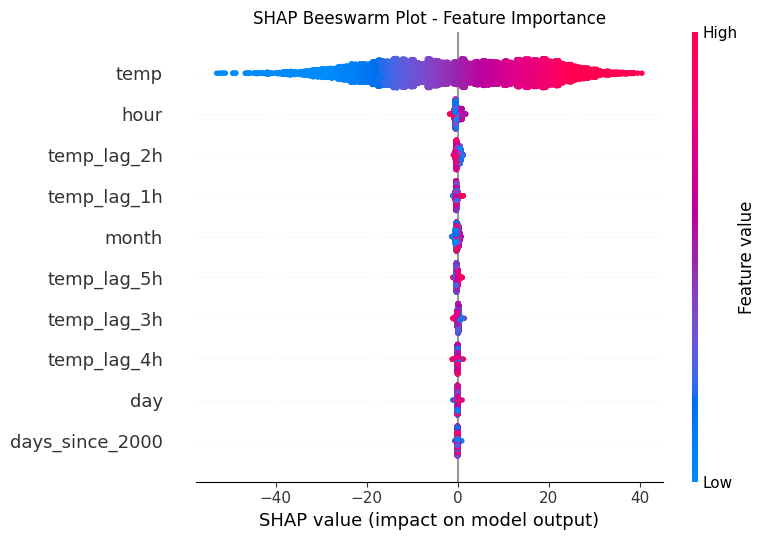

In [53]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import os

os.chdir('/home/zaccosenza/code/project-weather')

# Reference date for days_since feature
REFERENCE_DATE = pd.Timestamp('2000-01-01')

# Load and preprocess
df = pd.read_csv("data/01_raw/weather_data.csv")
df = df[pd.to_datetime(df['valid']) >= pd.to_datetime('2010-01-01')]
df['valid'] = pd.to_datetime(df['valid'], errors='coerce')
df['tmpf'] = pd.to_numeric(df['tmpf'], errors='coerce')
df = df.dropna(subset=['valid', 'tmpf']).sort_values('valid')

# Extract time features
df['month'] = df['valid'].dt.month
df['day'] = df['valid'].dt.day
df['hour'] = df['valid'].dt.hour
df['temp'] = df['tmpf']

# Add days since 2000-01-01 as a float (includes fractional days from hours)
df['days_since_2000'] = (df['valid'] - REFERENCE_DATE).dt.total_seconds() / (24 * 3600)

# Add last 24 hours of temperature as features
num_lags = 6
for i in range(1, num_lags):
    df[f'temp_lag_{i}h'] = df['tmpf'].shift(i)

# Drop rows with NaN values from lag features
df = df.dropna()

# Features: time features + days_since_2000 + current temp + lag features
feature_cols = ['month', 'day', 'hour', 'days_since_2000', 'temp'] + [f'temp_lag_{i}h' for i in range(1, num_lags)]
X = df[feature_cols].iloc[:-1]
y = df['tmpf'].shift(-1).iloc[:-1]

# Drop any remaining NaN from target shift
valid_idx = ~y.isna()
X = X[valid_idx]
y = y[valid_idx]

# Train/test split (random, 10% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Train XGBoost regressor
model = XGBRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Test MSE: {mse:.3f}")


# Plot actual vs predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Actual Temperature (°F)")
plt.ylabel("Predicted Temperature (°F)")
plt.title("XGBoost Regression: Actual vs Predicted Temperature")
plt.grid(True)
plt.tight_layout()
plt.show()

# Calculate and save errors by time
results_df = X_test.copy()
results_df['true_tmpf'] = y_test.values
results_df['pred_tmpf'] = y_pred
results_df['abs_error'] = np.abs(y_test - y_pred)

error_by_time = results_df.groupby(['month', 'day', 'hour'])['abs_error'].mean().reset_index()

# SHAP beeswarm plot
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test)

plt.figure(figsize=(12, 10))
shap.plots.beeswarm(shap_values, show=False)
plt.title("SHAP Beeswarm Plot - Feature Importance")
plt.tight_layout()
plt.show()

/tmp/ipykernel_232762/297265906.py:5: DtypeWarning: Columns (2,3,4,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_r2 = pd.read_csv("data/01_raw/weather_data.csv")


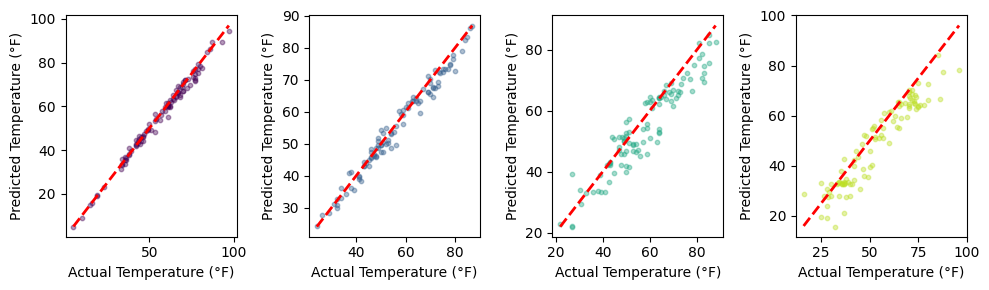

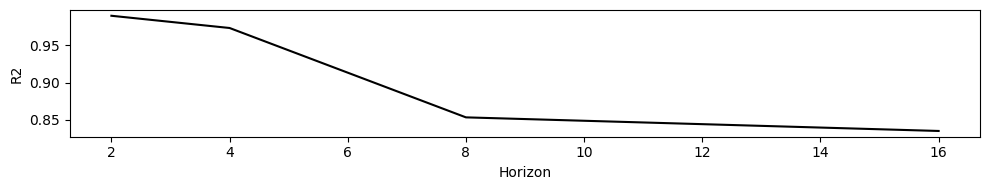

R2 Average: 0.9127078510764903
MAE Average: 3.4200096480846405


In [54]:
# R² plot for predicting next N hours using autoregressive inference
from sklearn.metrics import r2_score

# Reload and preprocess data for multi-horizon prediction
df_r2 = pd.read_csv("data/01_raw/weather_data.csv")
df_r2['valid'] = pd.to_datetime(df_r2['valid'], errors='coerce')
df_r2['tmpf'] = pd.to_numeric(df_r2['tmpf'], errors='coerce')
df_r2 = df_r2.dropna(subset=['valid', 'tmpf']).sort_values('valid').reset_index(drop=True)

# Extract time features
df_r2['month'] = df_r2['valid'].dt.month
df_r2['day'] = df_r2['valid'].dt.day
df_r2['hour'] = df_r2['valid'].dt.hour
df_r2['temp'] = df_r2['tmpf']

# Add days since 2000-01-01 as a float
df_r2['days_since_2000'] = (df_r2['valid'] - REFERENCE_DATE).dt.total_seconds() / (24 * 3600)

# Add lag features
for i in range(1, num_lags):
    df_r2[f'temp_lag_{i}h'] = df_r2['tmpf'].shift(i)

# Drop rows with NaN from lag features
df_r2 = df_r2.dropna().reset_index(drop=True)

# Define prediction horizons (N hours ahead)
horizons = [2, 4, 8, 16]
colors = plt.cm.viridis(np.linspace(0, 0.9, len(horizons)))

feature_cols = ['month', 'day', 'hour', 'days_since_2000', 'temp'] + [f'temp_lag_{i}h' for i in range(1, num_lags)]

def autoregressive_predict(model, initial_row, n_hours):
    """
    Use the trained 1-step model autoregressively to predict N hours ahead.
    Each prediction becomes input for the next step.
    Returns: (final_prediction, full_forecast_sequence)
    """
    # Start with initial features
    current_temps = [initial_row['temp']] + [initial_row[f'temp_lag_{i}h'] for i in range(1, num_lags)]
    month = initial_row['month']
    day = initial_row['day']
    hour = initial_row['hour']
    days_since_2000 = initial_row['days_since_2000']

    # Autoregressively predict N steps
    forecast = [current_temps[0]]  # Start with initial temp
    for step in range(n_hours):
        features = pd.DataFrame([[month, day, hour, days_since_2000, current_temps[0]] + current_temps[1:num_lags]],
                                columns=feature_cols)
        next_temp = model.predict(features)[0]
        current_temps = [next_temp] + current_temps[:-1]
        forecast.append(next_temp)

        # Advance time by 1 hour
        days_since_2000 += 1/24  # Add 1 hour in days
        hour = (hour + 1) % 24
        if hour == 0:
            day = day + 1
            if day > 28:  # Simplified month handling
                day = 1
                month = (month % 12) + 1

    return next_temp, forecast

r2_scores = []
mae_scores = []

fig, axes = plt.subplots(1, len(horizons), figsize=(10, 3))
axes = axes.flatten()

for idx, (n_hours, color) in enumerate(zip(horizons, colors)):
    # Get samples where we have ground truth N hours ahead
    max_idx = len(df_r2) - n_hours
    
    # Sample indices for evaluation (use subset for efficiency)
    np.random.seed(42)
    sample_size = min(100, max_idx)
    sample_indices = np.random.choice(max_idx, size=sample_size, replace=False)
    
    y_true_list = []
    y_pred_list = []
    
    for i in sample_indices:
        # Get initial row
        initial_row = df_r2.iloc[i]
        
        # Get ground truth N hours ahead
        y_true = df_r2.iloc[i + n_hours]['tmpf']
        
        # Autoregressive prediction
        y_pred, _ = autoregressive_predict(model, initial_row, n_hours)
        
        y_true_list.append(y_true)
        y_pred_list.append(y_pred)
    
    y_true_arr = np.array(y_true_list)
    y_pred_arr = np.array(y_pred_list)
    r2 = r2_score(y_true_arr, y_pred_arr)
    mae = sum(abs(y_true_arr - y_pred_arr)) / len(y_true_arr)
    r2_scores.append(r2)
    mae_scores.append(mae)
    
    # Plot actual vs predicted
    ax = axes[idx]
    ax.scatter(y_true_arr, y_pred_arr, alpha=0.4, color=color, s=10)
    ax.plot([y_true_arr.min(), y_true_arr.max()], [y_true_arr.min(), y_true_arr.max()], 'r--', linewidth=2)
    ax.set_xlabel("Actual Temperature (°F)")
    ax.set_ylabel("Predicted Temperature (°F)")

plt.tight_layout()
plt.show()

plt.figure(figsize = (10,2))
plt.plot(horizons, r2_scores, 'k')
plt.xlabel('Horizon')
plt.ylabel('R2')
plt.tight_layout()
plt.show()

print(f'R2 Average: {sum(r2_scores) / len(r2_scores)}')
print(f'MAE Average: {sum(mae_scores) / len(mae_scores)}')

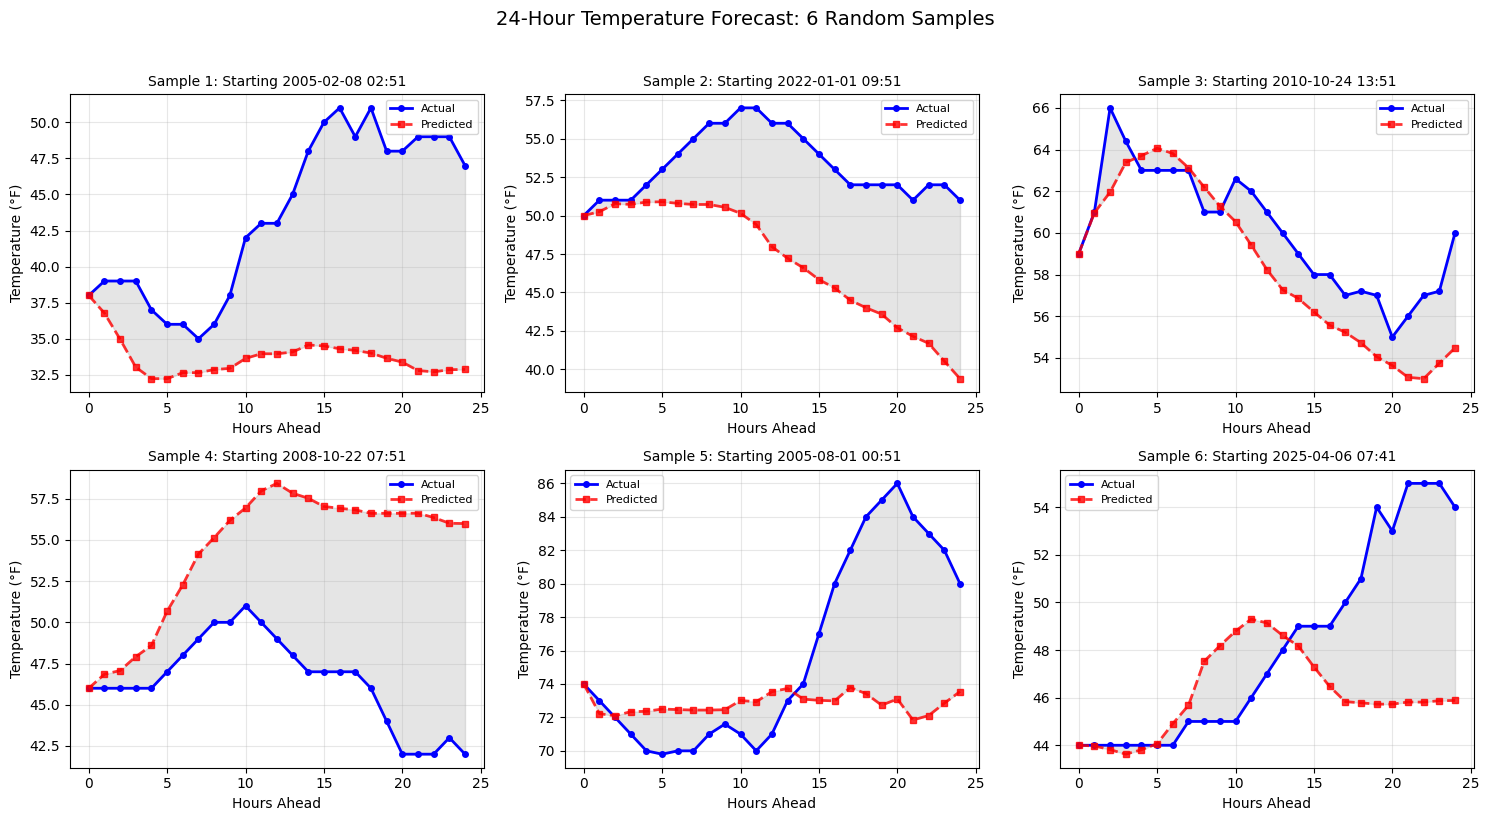


Summary for 6 samples:
  Sample 1: MAE = 10.05°F
  Sample 2: MAE = 6.40°F
  Sample 3: MAE = 2.09°F
  Sample 4: MAE = 8.26°F
  Sample 5: MAE = 4.88°F
  Sample 6: MAE = 3.48°F
  Average MAE: 5.86°F


In [55]:
# Plot N random samples with 24-hour predictions vs actual data
N_samples = 6  # Number of random samples to plot
prediction_horizon = 24  # Hours to predict ahead

# Get valid starting indices (need 24 hours of future data)
max_idx = len(df_r2) - prediction_horizon

# Sample N random starting points
np.random.seed(123)
sample_indices = np.random.choice(max_idx, size=N_samples, replace=False)

# Create subplot grid
n_cols = 3
n_rows = (N_samples + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()

for idx, start_idx in enumerate(sample_indices):
    initial_row = df_r2.iloc[start_idx]
    
    # Get actual temperatures for next 24 hours
    actual_temps = df_r2.iloc[start_idx:start_idx + prediction_horizon + 1]['tmpf'].values
    actual_times = df_r2.iloc[start_idx:start_idx + prediction_horizon + 1]['valid'].values
    
    # Get predicted temperatures (forecast already includes initial temp)
    _, predicted_temps = autoregressive_predict(model, initial_row, prediction_horizon)
    
    # Create hour labels (0 to 24)
    hours_ahead = np.arange(len(actual_temps))
    
    ax = axes[idx]
    ax.plot(hours_ahead, actual_temps, 'b-o', label='Actual', markersize=4, linewidth=2)
    ax.plot(hours_ahead, predicted_temps, 'r--s', label='Predicted', markersize=4, linewidth=2, alpha=0.8)
    
    # Fill between to show error
    ax.fill_between(hours_ahead, actual_temps, predicted_temps, alpha=0.2, color='gray')
    
    start_date = pd.to_datetime(actual_times[0])
    ax.set_title(f"Sample {idx + 1}: Starting {start_date.strftime('%Y-%m-%d %H:%M')}", fontsize=10)
    ax.set_xlabel("Hours Ahead")
    ax.set_ylabel("Temperature (°F)")
    ax.legend(loc='best', fontsize=8)
    ax.grid(True, alpha=0.3)

# Hide unused subplots
for idx in range(N_samples, len(axes)):
    axes[idx].set_visible(False)

plt.suptitle(f"24-Hour Temperature Forecast: {N_samples} Random Samples", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nSummary for {N_samples} samples:")
total_mae = 0
for idx, start_idx in enumerate(sample_indices):
    initial_row = df_r2.iloc[start_idx]
    actual = df_r2.iloc[start_idx + 1:start_idx + prediction_horizon + 1]['tmpf'].values
    _, forecast = autoregressive_predict(model, initial_row, prediction_horizon)
    predicted = forecast[1:]  # Exclude initial temp, get only predictions
    mae = np.mean(np.abs(np.array(actual) - np.array(predicted)))
    total_mae += mae
    print(f"  Sample {idx + 1}: MAE = {mae:.2f}°F")
print(f"  Average MAE: {total_mae / N_samples:.2f}°F")